## GA+Signals

In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import datetime as dt
from datetime import date, datetime, timedelta
from pandas_datareader import data as web
import yfinance as yf

In [2]:
trading_period = 365
Stock = 'NDX'

In [4]:
yf.pdr_override()
start_date = dt.datetime(2019,1,1)
end_date = dt.datetime(2019,12,31)
df = web.get_data_yahoo(Stock, start_date, end_date)
X_train = df.dropna()
#X_train = X_train.divide(X_train.iloc[0] )
file_name_train = 'dataset/'+Stock+'_train.csv'
display(file_name_train)
X_train.to_csv(file_name_train, sep=',', encoding='utf-8')
print(X_train.head())

[*********************100%***********************]  1 of 1 completed


'dataset/NDX_train.csv'

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-02  6198.680176  6394.740234  6198.680176  6360.870117  6360.870117   
2019-01-03  6274.759766  6292.680176  6139.399902  6147.129883  6147.129883   
2019-01-04  6250.049805  6445.200195  6234.589844  6422.669922  6422.669922   
2019-01-07  6434.549805  6521.439941  6412.979980  6488.250000  6488.250000   
2019-01-08  6555.910156  6574.729980  6457.000000  6551.850098  6551.850098   

                Volume  
Date                    
2019-01-02  2261800000  
2019-01-03  2631550000  
2019-01-04  2596150000  
2019-01-07  2523450000  
2019-01-08  2407340000  


In [5]:
yf.pdr_override()
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2021,12,31)
df = web.get_data_yahoo(Stock, start_date, end_date)
X_test = df.dropna()
file_name_test = 'dataset/'+Stock+'_test.csv'
display(file_name_test)
X_test.to_csv(file_name_test, sep=',', encoding='utf-8')

print(X_test.head())

[*********************100%***********************]  1 of 1 completed


'dataset/NDX_test.csv'

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-02  8802.219727  8873.629883  8786.900391  8872.219727  8872.219727   
2020-01-03  8755.169922  8843.650391  8755.169922  8793.900391  8793.900391   
2020-01-06  8713.889648  8849.980469  8713.889648  8848.519531  8848.519531   
2020-01-07  8857.139648  8872.469727  8821.679688  8846.450195  8846.450195   
2020-01-08  8845.450195  8953.549805  8834.940430  8912.370117  8912.370117   

                Volume  
Date                    
2020-01-02  2862700000  
2020-01-03  2586520000  
2020-01-06  2810450000  
2020-01-07  2381740000  
2020-01-08  2472620000  


In [6]:
df = pd.read_csv('dataset/NDX_train.csv')
df = df.drop('Date',axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
0,6198.680176,6394.740234,6198.680176,6360.870117,6360.870117,2261800000
1,6274.759766,6292.680176,6139.399902,6147.129883,6147.129883,2631550000
2,6250.049805,6445.200195,6234.589844,6422.669922,6422.669922,2596150000
3,6434.549805,6521.439941,6412.979980,6488.250000,6488.250000,2523450000
4,6555.910156,6574.729980,6457.000000,6551.850098,6551.850098,2407340000


In [7]:
def calculate_signal(df):
    short_window = int(0.025 * len(df))
    long_window = int(0.05 * len(df))

    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                                > signals['long_ma'][short_window:], 1.0, 0.0)   
    signals['positions'] = signals['signal'].diff()

    #signals
    position=signals['positions']
    
    return position

In [8]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [9]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
        return np.maximum(X, 0)
        
def softmax(X):
        e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
        a1 = np.dot(X, nets.W1)
        z1 = relu(a1)
        a2 = np.dot(z1, nets.W2)
        return softmax(a2)

In [10]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual, trends):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(trends) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= trends[t] and position[t]==1:
                inventory.append(trends[t])
                initial_money -= trends[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, trends[t], initial_money))
            
            elif action == 2 and len(inventory) and position[t]==-1 :
                bought_price = inventory.pop(0)
                initial_money += trends[t]
                states_sell.append(t)
                try:
                    invest = ((trends[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, trends[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t] and position[t]==1:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) and position[t]==-1 :
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        start=time.time()
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        end=time.time()
        print("Time :")
        print(end-start)
        return fittest_individual

In [11]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)
position=calculate_signal(df)

In [12]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 17.764302
epoch 10, fittest individual 0 with accuracy 19.146499
epoch 15, fittest individual 0 with accuracy 19.146499
epoch 20, fittest individual 0 with accuracy 19.146499
epoch 25, fittest individual 0 with accuracy 19.146499
epoch 30, fittest individual 0 with accuracy 19.146499
epoch 35, fittest individual 0 with accuracy 19.146499
epoch 40, fittest individual 0 with accuracy 19.146499
epoch 45, fittest individual 0 with accuracy 19.146499
epoch 50, fittest individual 0 with accuracy 19.146499
Time :
66.35968589782715


In [14]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close)

day 6: buy 1 unit at price 6620.939941, total balance 3379.060059
day 49: buy 1 unit at price 7243.009766, total balance -3863.949707
day 86, sell 1 unit at price 7640.149902, investment 15.393735 %, total balance 3776.200195,
day 109: buy 1 unit at price 7501.930176, total balance -3725.729980
day 161: buy 1 unit at price 7707.430176, total balance -11433.160156
day 235, sell 1 unit at price 8397.370117, investment 15.937578 %, total balance -3035.790039,


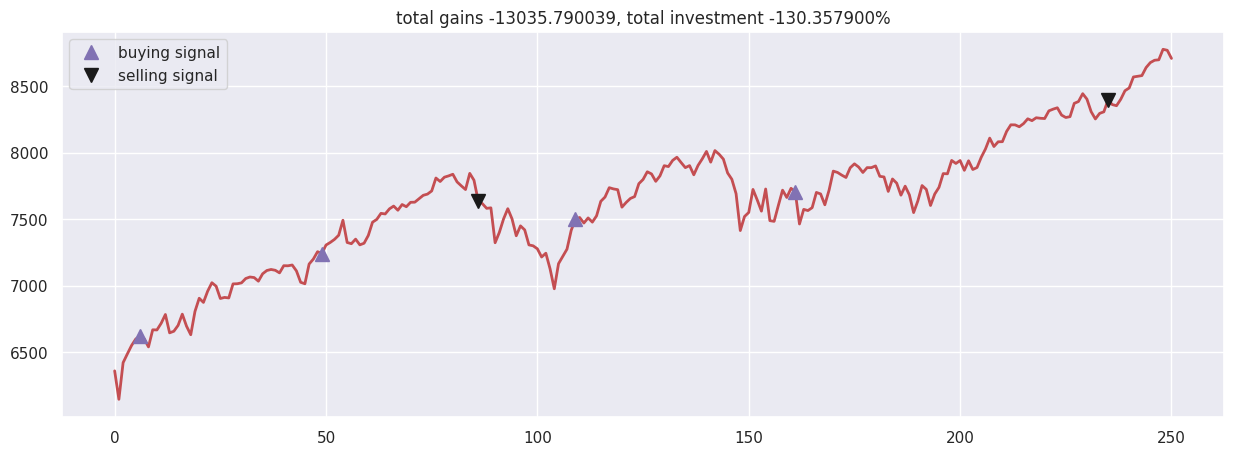

In [15]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [16]:
df = pd.read_csv('/content/dataset/NDX_test.csv')
df = df.drop("Date",axis=1)
df = df.iloc[:251]
print(df)

             Open          High           Low         Close     Adj Close  \
0     8802.219727   8873.629883   8786.900391   8872.219727   8872.219727   
1     8755.169922   8843.650391   8755.169922   8793.900391   8793.900391   
2     8713.889648   8849.980469   8713.889648   8848.519531   8848.519531   
3     8857.139648   8872.469727   8821.679688   8846.450195   8846.450195   
4     8845.450195   8953.549805   8834.940430   8912.370117   8912.370117   
..            ...           ...           ...           ...           ...   
246  12715.480469  12761.230469  12606.419922  12717.559570  12717.559570   
247  12733.750000  12737.589844  12649.599609  12653.139648  12653.139648   
248  12668.200195  12732.549805  12665.799805  12711.009766  12711.009766   
249  12813.969727  12861.910156  12747.049805  12838.860352  12838.860352   
250  12909.860352  12925.530273  12816.589844  12843.490234  12843.490234   

         Volume  
0    2862700000  
1    2586520000  
2    2810450000  
3  

In [17]:
close2 = df.Close.values.tolist()
position=calculate_signal(df)

In [18]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close2)

day 6: buy 1 unit at price 8966.639648, total balance 1033.360352
day 23: buy 1 unit at price 9367.480469, total balance -8334.120117


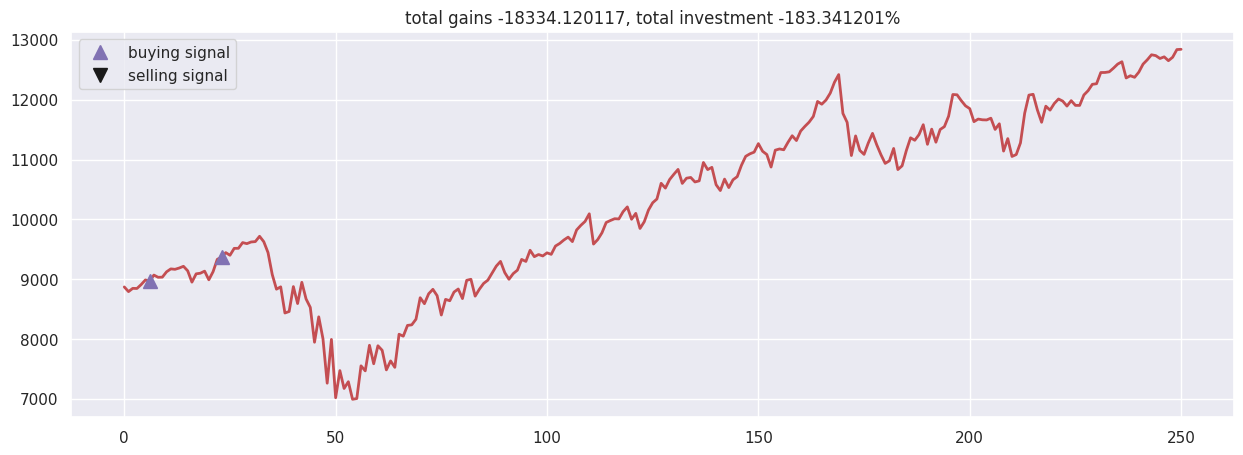

In [19]:
fig = plt.figure(figsize = (15,5))
plt.plot(close2, color='r', lw=2.)
plt.plot(close2, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close2, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

##GA

In [20]:
df = pd.read_csv('/content/dataset/NDX_train.csv')
df.shape

(251, 7)

In [21]:
df = df.drop("Date",axis=1)

In [22]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [23]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [24]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual, trends):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(trends) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= trends[t]:
                inventory.append(trends[t])
                initial_money -= trends[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, trends[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += trends[t]
                states_sell.append(t)
                try:
                    invest = ((trends[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, trends[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
        
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [25]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [26]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 26.148608
epoch 10, fittest individual 0 with accuracy 27.583306
epoch 15, fittest individual 49 with accuracy 33.300317
epoch 20, fittest individual 0 with accuracy 33.300317
epoch 25, fittest individual 0 with accuracy 33.300317
epoch 30, fittest individual 0 with accuracy 33.554170
epoch 35, fittest individual 0 with accuracy 33.554170
epoch 40, fittest individual 0 with accuracy 37.837324
epoch 45, fittest individual 0 with accuracy 37.837324
epoch 50, fittest individual 0 with accuracy 37.837324


In [27]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close)

day 1: buy 1 unit at price 6147.129883, total balance 3852.870117
day 2: buy 1 unit at price 6422.669922, total balance -2569.799805
day 3: buy 1 unit at price 6488.250000, total balance -9058.049805
day 4, sell 1 unit at price 6551.850098, investment 6.583889 %, total balance -2506.199707,
day 5: buy 1 unit at price 6600.689941, total balance -9106.889648
day 6: buy 1 unit at price 6620.939941, total balance -15727.829590
day 8: buy 1 unit at price 6541.040039, total balance -22268.869629
day 9: buy 1 unit at price 6669.640137, total balance -28938.509766
day 10: buy 1 unit at price 6668.560059, total balance -35607.069824
day 12, sell 1 unit at price 6784.609863, investment 5.635350 %, total balance -28822.459961,
day 14, sell 1 unit at price 6658.759766, investment 2.627978 %, total balance -22163.700195,
day 15: buy 1 unit at price 6702.549805, total balance -28866.250000
day 17: buy 1 unit at price 6697.089844, total balance -35563.339844
day 18: buy 1 unit at price 6632.790039, t

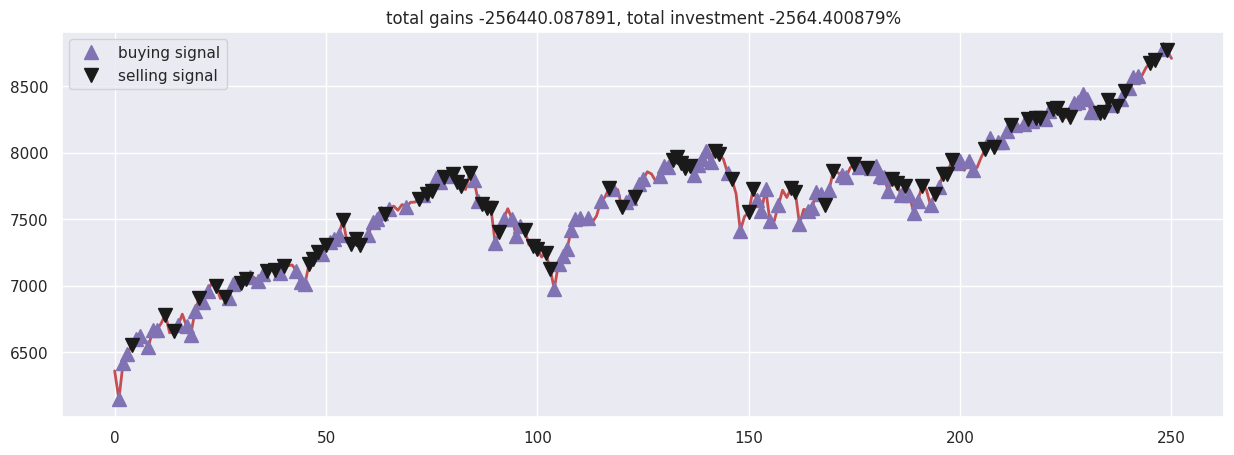

In [28]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [29]:
df = pd.read_csv('/content/dataset/NDX_test.csv')
df = df.drop("Date",axis=1)
df = df.iloc[:251]
print(len(df))
close2 = df.Close.values.tolist()

251


In [30]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close2)

day 1: buy 1 unit at price 8793.900391, total balance 1206.099609
day 2: buy 1 unit at price 8848.519531, total balance -7642.419922
day 3: buy 1 unit at price 8846.450195, total balance -16488.870117
day 4, sell 1 unit at price 8912.370117, investment 1.347181 %, total balance -7576.500000,
day 5: buy 1 unit at price 8989.629883, total balance -16566.129883
day 6: buy 1 unit at price 8966.639648, total balance -25532.769531
day 8: buy 1 unit at price 9033.419922, total balance -34566.189453
day 9: buy 1 unit at price 9035.669922, total balance -43601.859375
day 10: buy 1 unit at price 9125.000000, total balance -52726.859375
day 12, sell 1 unit at price 9166.629883, investment 3.595069 %, total balance -43560.229492,
day 14, sell 1 unit at price 9216.980469, investment 4.188463 %, total balance -34343.249023,
day 15: buy 1 unit at price 9141.469727, total balance -43484.718750
day 17: buy 1 unit at price 9090.929688, total balance -52575.648438
day 18: buy 1 unit at price 9101.610352,

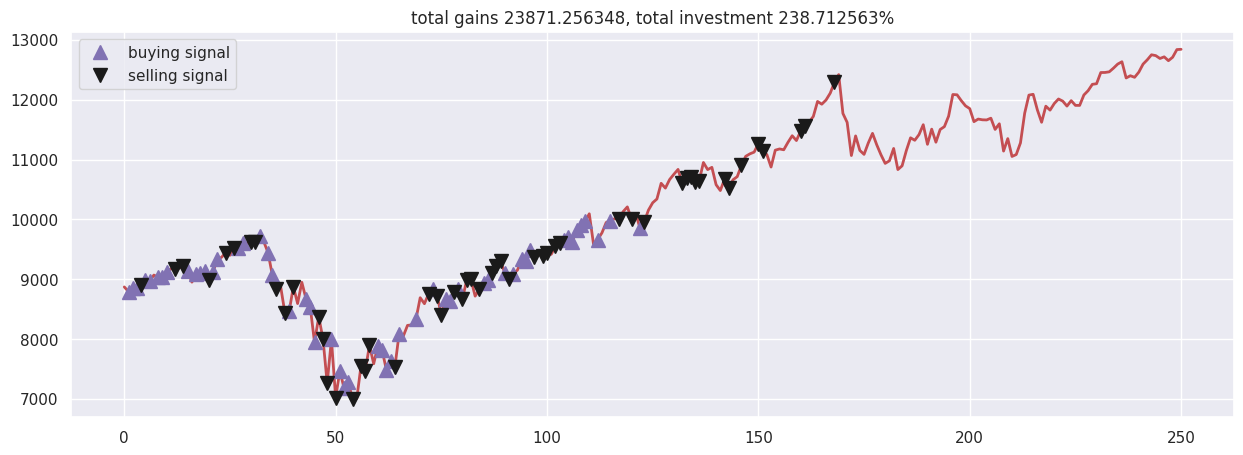

In [31]:
fig = plt.figure(figsize = (15,5))
plt.plot(close2, color='r', lw=2.)
plt.plot(close2, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close2, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()